Gu Huaqing Github Username: JuliaGHQ USC ID: 2433803934

In [ ]:
# Common
import os 
import cv2
import keras 
import random
import numpy as np
import tensorflow as tf

# Data Loading
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
import tensorflow_hub as hub
from keras.models import Sequential, load_model
from keras.layers import Dense

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Optimizer
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras import applications, optimizers
from pathlib import Path

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


***(a)&(b) Split folders and Choose batch size and do VGG***

In [ ]:
#Split image files in training set, validation set, and testing set in ratio(0.7,0.15,0.15).

import splitfolders

input_folder = '/content/drive/MyDrive/Colab Notebooks/552/images'
splitfolders.ratio(input_folder, output="output", seed=1, ratio=(0.7, 0.15,0.15), group_prefix=None, move=False) 



Copying files: 1176 files [06:06,  3.21 files/s]


In [ ]:
#Make sure the Batch size for processing and set the ImageDataGenerator to do the image augementation for train, validation and test sets. 
#The number of samples that will be propagated through the network is 64 to make sure the model is more  accurate. 
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     shear_range=0.2,
                                     zoom_range=[0.1, 0.7],
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  # VGG16 preprocessingw
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessingw

In [ ]:
#Import the image or the data from the file path. 
download_dir = Path('/content/drive/MyDrive/Colab Notebooks/552/images')

In [ ]:
train_data_dir = "/content/output/train"
test_data_dir = "/content/output/test"
valid_data_dir = "/content/output/val"

*Do One Hot Encoding for the Dataset*

In [ ]:
#Separate train, valid and test sets with target size and one hot encoding. 
class_subset = sorted(os.listdir(download_dir))

train_gen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

valid_gen = val_generator.flow_from_directory(valid_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',       #OneHotEncoder
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               seed=42)

test_gen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.
Found 185 images belonging to 20 classes.


**(c) Transfer learning VGG model and use Relu and train the VGG model for at least 50 epochs**

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
   
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
   
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    #Add layers to the model
    #Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization
    #and a dropout rate of 20% as well as ADAM optimizer.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
   
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    
    ##Compile the model.
    #Use multinomial cross entropy loss.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',               #OneHotEncoder
                  metrics=['accuracy'])
    
    return model

In [ ]:
#Define the shape, the optimizer, the learning rate, class numbers and epoches for the VGG model runnning.
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes = 20    

n_steps = train_gen.samples // BATCH_SIZE
n_val_steps = valid_gen.samples // BATCH_SIZE
n_epochs = 50       

vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

#Set a checkpoint for VGG model.
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

#EarlyStopping using validation set.
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

**Plot the Training and Validation errors vs. epochs graph**

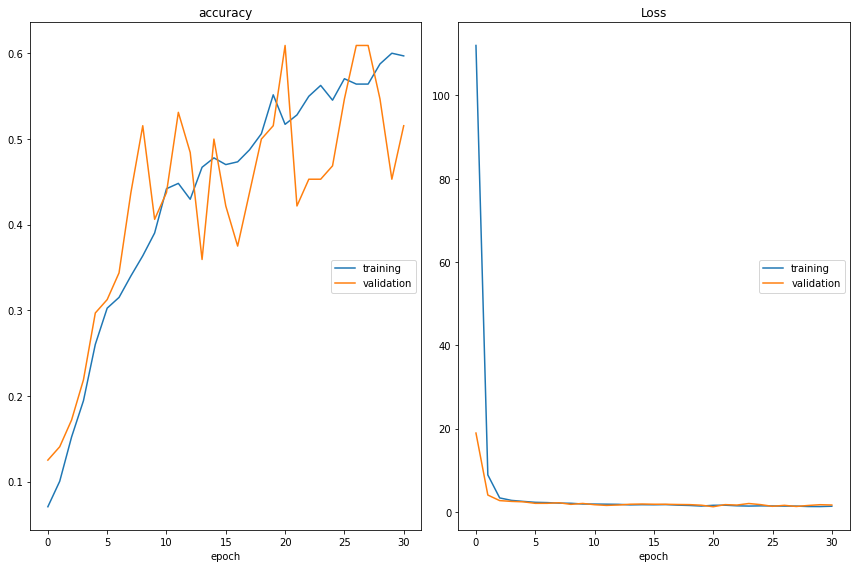

accuracy
	training         	 (min:    0.071, max:    0.600, cur:    0.597)
	validation       	 (min:    0.125, max:    0.609, cur:    0.516)
Loss
	training         	 (min:    1.278, max:  112.012, cur:    1.359)
	validation       	 (min:    1.238, max:   18.934, cur:    1.653)
10/10 [==============================] - 14s 1s/step - loss: 1.3591 - accuracy: 0.5972 - val_loss: 1.6533 - val_accuracy: 0.5156
CPU times: user 8min 29s, sys: 25 s, total: 8min 54s
Wall time: 10min 30s


In [ ]:
#Plot the graph with training and validation together. 
%%time 

vgg_history = vgg_model.fit(train_gen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=valid_gen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

From the graph above, the accuracy and loss analysis on the bottom, we see that the the training and validation accuracy continue to increase during the VGG model training. The highest training accuracy is around 0.6, and the highest validation accuracy is around 0.61. The loss continue to decrease in the VGG model training, it is a good sign. 

**Get the test results，average model accuracy and report the Precision, Recall, and F1 scores (Classification Report for multi-class.)**

In [ ]:
#Initialize the best trained weights
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') 

#Set the true classes and pred classes
true_classes = test_gen.classes
class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(test_gen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

185/185 [==============================] - 3s 11ms/step


In [ ]:
vgg_preds

array([[9.9656641e-01, 3.5966295e-04, 4.7375767e-12, ..., 1.6181904e-13,
        1.0735777e-15, 1.5631701e-11],
       [4.3285523e-02, 2.6902987e-11, 6.1987340e-13, ..., 4.7721016e-16,
        2.0923071e-15, 5.7237171e-12],
       [1.4105080e-02, 7.0599908e-11, 1.1700004e-11, ..., 2.3276925e-12,
        1.3902761e-12, 3.8471362e-11],
       ...,
       [9.7693085e-16, 6.2858671e-18, 6.3477037e-09, ..., 1.9301216e-17,
        1.1306028e-06, 9.9999893e-01],
       [3.7853633e-31, 0.0000000e+00, 2.3182029e-25, ..., 1.2352916e-31,
        5.8484454e-12, 1.0000000e+00],
       [9.8774342e-15, 4.6411017e-20, 1.2416284e-14, ..., 3.2773070e-10,
        2.3629819e-04, 9.9976367e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score
#Get the  average accuracy for the VGG model.
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy : {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy : 62.16%


The VGG model accuracy for this training model is 62.16%, which is a fair percentage of accracy. 

## The Classification Report for VGG model:

In [ ]:
from PIL import Image
from sklearn.metrics import classification_report

In [ ]:
y_true = true_classes
y_pred = vgg_pred_classes

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.67      0.44      0.53         9
           2       0.62      0.50      0.56        10
           3       0.58      0.70      0.64        10
           4       0.29      0.44      0.35         9
           5       0.54      0.78      0.64         9
           6       0.78      0.78      0.78         9
           7       0.80      0.44      0.57         9
           8       1.00      0.78      0.88         9
           9       1.00      0.44      0.62         9
          10       0.75      0.67      0.71         9
          11       0.89      0.89      0.89         9
          12       1.00      0.11      0.20         9
          13       0.58      0.78      0.67         9
          14       0.39      0.78      0.52         9
          15       0.25      0.10      0.14        10
          16       0.91      1.00      0.95        10
          17       0.83    

Above is the classification report of the VGG model. 

**Reference**

https://github.com/jfilter/split-folders/blob/main/README.md

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/

https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

https://keras.io/api/layers/normalization_layers/batch_normalization/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

https://scikit-learn.org/stable/modules/model_evaluation.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673

https://medium.com/analytics-vidhya/image-classification-with-vgg-convolutional-neural-network-using-keras-for-beginners-61767950c5dd

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://pypi.org/project/livelossplot/

https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py

